In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np 
import pandas as pd 
import cv2 
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image

Using TensorFlow backend.


In [2]:
facenet_model = load_model('facenet_keras.h5')
print('Loaded Model')

Loaded Model


c:\Users\nikhi\anaconda3\envs\myenv\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
import os
print(os.listdir("data"))

['Test', 'Train']


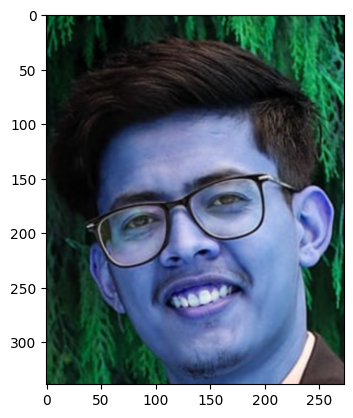

(339, 273, 3)


In [4]:
img = cv2.imread('data/Train/kan076bct004/2.jpg')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.show()
print(img.shape)

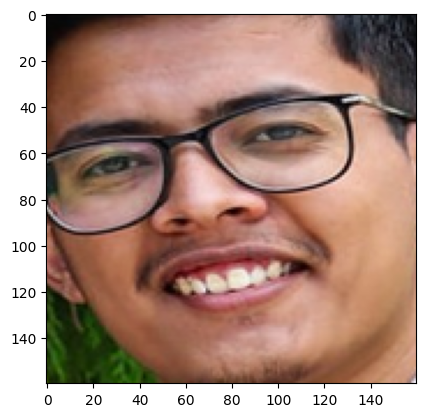

(160, 160, 3)


In [5]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load the photo and extract the face
pixels = extract_face('data/Train/kan076bct004/2.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

In [6]:
def load_face(dir):
    faces = list()
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


trainX, trainy = load_dataset('data/Train/')
print(trainX.shape, trainy.shape)
testX, testy = load_dataset('data/Test/')
print(testX.shape, testy.shape)

# save and compress the dataset 
np.savez_compressed('kec-students-076.npz', trainX, trainy, testX, testy)

loaded 8 sample for class: kan076bct004
loaded 5 sample for class: kan076bct005
loaded 5 sample for class: kan076bct007
loaded 8 sample for class: kan076bct008
loaded 5 sample for class: kan076bct009
loaded 5 sample for class: kan076bct011
loaded 7 sample for class: kan076bct012
loaded 8 sample for class: kan076bct015
loaded 5 sample for class: kan076bct016
loaded 5 sample for class: kan076bct018
loaded 5 sample for class: kan076bct020
loaded 9 sample for class: kan076bct021
loaded 5 sample for class: kan076bct022
loaded 7 sample for class: kan076bct024
loaded 6 sample for class: kan076bct030
loaded 8 sample for class: kan076bct033
loaded 6 sample for class: kan076bct035
loaded 5 sample for class: kan076bct036
loaded 4 sample for class: kan076bct037
loaded 7 sample for class: kan076bct038
loaded 7 sample for class: kan076bct039
loaded 5 sample for class: kan076bct040
loaded 4 sample for class: kan076bct041
loaded 5 sample for class: kan076bct044
loaded 3 sample for class: kan076bct045


In [7]:
data = np.load('kec-students-076.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (158, 160, 160, 3) (158,) (52, 160, 160, 3) (52,)


In [8]:
def get_embedding(model, face):
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    sample = np.expand_dims(face, axis=0)
    yhat = model.predict(sample)
    return yhat[0]
    

emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)


emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)


np.savez_compressed('kec-students-076.npz', emdTrainX, trainy, emdTestX, testy)

(158, 128)
(52, 128)


In [9]:
# from sklearn.metrics import accuracy_score
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import Normalizer
# from sklearn.svm import SVC

# print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# # normalize input vectors
# in_encoder = Normalizer()
# emdTrainX_norm = in_encoder.transform(emdTrainX)
# emdTestX_norm = in_encoder.transform(emdTestX)
# # label encode targets
# out_encoder = LabelEncoder()
# out_encoder.fit(trainy)
# trainy_enc = out_encoder.transform(trainy)
# testy_enc = out_encoder.transform(testy)
# # fit model
# model = SVC(kernel='linear', probability=True)
# model.fit(emdTrainX_norm, trainy_enc)
# # predict
# yhat_train = model.predict(emdTrainX_norm)
# yhat_test = model.predict(emdTestX_norm)
# # score
# score_train = accuracy_score(trainy_enc, yhat_train)
# score_test = accuracy_score(testy_enc, yhat_test)
# # summarize
# print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=158, test=52
Accuracy: train=100.000, test=100.000


Predicted: 
['kan076bct004' 'kan076bct005' 'kan076bct007' 'kan076bct008'
 'kan076bct009'] 
[ 2.06574498  4.75432536  3.87120186  2.32220497  1.14578452  2.64633415
  3.22633507  1.84712451  2.76824944  2.12414704  4.2352324  31.9758689
  1.72235766  1.39873848  3.26984039  2.3664994   2.03305728  2.08366529
  1.77415421  2.64630652  1.68730617  1.20739693  4.29874982  2.57776066
  5.15594471  1.71508212  3.08058715]
Expected: kan076bct021


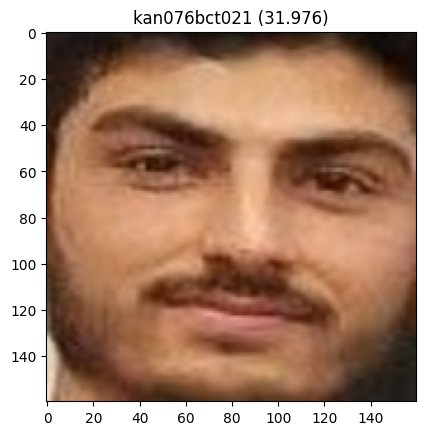

In [10]:
# from random import choice
# # select a random face from test set
# selection = choice([i for i in range(testX.shape[0])])
# random_face = testX[selection]
# random_face_emd = emdTestX_norm[selection]
# random_face_class = testy_enc[selection]
# random_face_name = out_encoder.inverse_transform([random_face_class])

# # prediction for the face
# samples = np.expand_dims(random_face_emd, axis=0)
# yhat_class = model.predict(samples)
# yhat_prob = model.predict_proba(samples)
# # get name
# class_index = yhat_class[0]
# class_probability = yhat_prob[0,class_index] * 100
# predict_names = out_encoder.inverse_transform(yhat_class)
# all_names = out_encoder.inverse_transform([0,1,2,3,4])
# #print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
# print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
# print('Expected: %s' % random_face_name[0])
# # plot face
# plt.imshow(random_face)
# title = '%s (%.3f)' % (predict_names[0], class_probability)
# plt.title(title)
# plt.show()

In [19]:
# image_path = 'prediction/neha.jpg'
# output_face = extract_face(image_path)
# embedding = get_embedding(facenet_model,output_face)
# # in_encoder = Normalizer()
# # normalized = in_encoder.transform(embedding)
# # random_face_class = testy_enc[output_face]
# # random_face_name = out_encoder.inverse_transform([random_face_class])

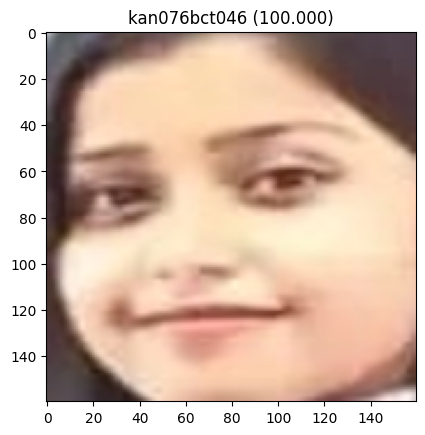

In [21]:
# # prediction for the face
# samples = np.expand_dims(embedding, axis=0)
# yhat_class = model.predict(samples)
# yhat_prob = model.predict_proba(samples)
# # get name
# class_index = yhat_class[0]
# class_probability = yhat_prob[0,class_index] * 100
# predict_names = out_encoder.inverse_transform(yhat_class)
# all_names = out_encoder.inverse_transform([0,1,2,3,4])
# #print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
# # print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
# # print('Expected: %s' % random_face_name[0])
# # plot face
# plt.imshow(output_face)
# title = '%s (%.3f)' % (predict_names[0], class_probability)
# plt.title(title)
# plt.show()